# SEC's EDGAR 통한 펀더멘탈 데이터

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
%matplotlib inline

from pathlib import Path
from datetime import date
import json
from io import BytesIO
from zipfile import ZipFile, BadZipFile
from tqdm import tqdm
import requests

import pandas as pd
import pandas_datareader.data as web

from pprint import pprint

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

In [3]:
sns.set_style('whitegrid')

In [4]:
# store data in this directory since we won't use it in other chapters
data_path = Path('data') # perhaps set to external harddrive to accomodate large amount of data
if not data_path.exists():
    data_path.mkdir()

## Download FS & Notes Data

[Financial Statement and Notes](https://www.sec.gov/dera/data/financial-statement-and-notes-data-set.html) (FSN) dataset 받아오기

In [15]:
SEC_URL = 'https://www.sec.gov/'
FSN_PATH = 'files/dera/data/financial-statement-and-notes-data-sets/'

In [131]:
filing_periods = [(d.year, d.quarter) for d in pd.date_range('2017-01-01', '2018-01-30', freq='Q')]
filing_periods

[(2017, 1), (2017, 2), (2017, 3), (2017, 4)]

In [132]:
for yr, qtr in tqdm(filing_periods):
    # 다운받을 디렉토리 정하기
    path = data_path / f'{yr}_{qtr}' / 'source'
    if not path.exists():
        path.mkdir(parents=True)
    
    # 다운받을 URL 정의
    filing = f'{yr}q{qtr}_notes.zip'
    url = SEC_URL + FSN_PATH + filing
    response = requests.get(url).content
    
    # 압축 풀어서 받기
    try:
        with ZipFile(BytesIO(response)) as zip_file:
            for file in zip_file.namelist():
                local_file = path / file
                if local_file.exists():
                    continue
                with local_file.open('wb') as output:
                    for line in zip_file.open(file).readlines():
                        output.write(line)
    except BadZipFile:
        print(f'\nBad zip file: {yr} {qtr}\n')
        continue

100%|███████████████████████████████████████████████████████████████████████████████████| 4/4 [13:21<00:00, 200.37s/it]


## Save to parquet

tsv 파일 파케이 파일로 바꿔주기

In [135]:
for f in tqdm(sorted(list(data_path.glob('**/*.tsv')))):
    # set (and create) directory
    parquet_path = f.parent.parent / 'parquet'
    if not parquet_path.exists():
        parquet_path.mkdir(parents=True)    

    # write content to .parquet
    file_name = f.stem  + '.parquet'
    if not (parquet_path / file_name).exists():
        try:
            df = pd.read_csv(f, sep='\t', encoding='latin1', low_memory=False, error_bad_lines=False)
            df.to_parquet(parquet_path / file_name)
        except Exception as e:
            print(e, ' | ', f)
        # optional: uncomment to delete original .tsv
#         else:
            # f.unlink

100%|██████████████████████████████████████████████████████████████████████████████████| 56/56 [03:58<00:00,  4.26s/it]


## Metadata json

In [55]:
file = data_path / '2019_3' / 'source' / '2019q3_notes-metadata.json'
with file.open() as f:
    data = json.load(f)

pprint(data)

{'@context': 'http://www.w3.org/ns/csvw',
 'dialect': {'delimiter': '\t', 'header': True, 'headerRowCount': 1},
 'tables': [{'tableSchema': {'aboutUrl': 'readme.htm',
                             'columns': [{'datatype': {'base': 'string',
                                                       'maxLength': 20,
                                                       'minLength': 20},
                                          'dc:description': 'Accession Number. '
                                                            'The 20-character '
                                                            'string formed '
                                                            'from the 18-digit '
                                                            'number assigned '
                                                            'by the Commission '
                                                            'to each EDGAR '
                                                           

                                          'titles': ['Date Preference']},
                                         {'datatype': {'base': 'string',
                                                       'maxLength': 34},
                                          'dc:description': 'The 32-byte '
                                                            'hexadecimal key '
                                                            'for the '
                                                            'dimensional '
                                                            'information in '
                                                            'the DIM data set.',
                                          'name': 'dimh',
                                          'titles': ['Dimension Hash']},
                                         {'datatype': {'base': 'decimal',
                                                       'minInclusive': 0},
                                         

                                                            'the tag for the '
                                                            'parent of the arc',
                                          'name': 'pversion',
                                          'required': 'true',
                                          'titles': ['Parent Namespace']},
                                         {'datatype': {'base': 'string',
                                                       'maxLength': 255},
                                          'dc:description': 'The tag for the '
                                                            'child of the arc',
                                          'name': 'ctag',
                                          'required': 'true',
                                          'titles': ['Child Tag']},
                                         {'datatype': {'base': 'string',
                                                       'maxLength': 20},
 

## Data Organization

FSN 데이터는 8개로 나뉘어 제공된다

| File | Dataset      | Description                                                 |
|------|--------------|-------------------------------------------------------------|
| SUB  | Submission   | Identifies each XBRL submission by company, form, date, etc |
| TAG  | Tag          | Defines and explains each taxonomy tag                      |
| DIM  | Dimension    | Adds detail to numeric and plain text data                  |
| NUM  | Numeric      | One row for each distinct data point in filing              |
| TXT  | Plain Text   | Contains all non-numeric XBRL fields                        |
| REN  | Rendering    | Information for rendering on SEC website                    |
| PRE  | Presentation | Detail on tag and number presentation in primary statements |
| CAL  | Calculation  | Shows arithmetic relationships among tags                   |

## Submission Data

In [97]:
sub = pd.read_parquet(data_path / '2019_1' / 'parquet' / 'sub.parquet')
sub.head()

,adsh,cik,name,sic,countryba,stprba,cityba,zipba,bas1,bas2,...,accepted,prevrpt,detail,instance,nciks,aciks,pubfloatusd,floatdate,floataxis,floatmems
0,0000940944-19-000005,940944,DARDEN RESTAURANTS INC,5812.0,US,FL,ORLANDO,32837,1000 DARDEN CENTER DRIVE,None,...,2019-01-02 16:13:00.0,0,1,dri-20181125.xml,1,None,NaN,NaN,None,NaN
1,0000023217-19-000002,23217,CONAGRA BRANDS INC.,2000.0,US,IL,CHICAGO,60654,222 W. MERCHANDISE MART PLAZA,SUITE 1300,...,2019-01-03 10:09:00.0,0,1,cag-20181125.xml,1,None,NaN,NaN,None,NaN
2,0001185185-19-000011,1502152,"ANGIOSOMA, INC.",2834.0,US,TX,HOUSTON,77042,"2500 WILCREST DRIVE, 3RD FLOOR",None,...,2019-01-02 21:51:00.0,0,1,soan-20180930.xml,1,None,401832.0,20180331.0,None,NaN
3,0001193125-19-001543,1084765,RESOURCES CONNECTION INC,7389.0,US,CA,IRVINE,92614,17101 ARMSTRONG AVENUE,None,...,2019-01-03 16:07:00.0,0,1,recn-20181124.xml,1,None,NaN,NaN,None,NaN
4,0001213900-19-000128,842013,HASH LABS INC.,7372.0,US,FL,BOCA RATON,33431,301 YAMATO ROAD,SUITE 1140,...,2019-01-03 14:29:00.0,1,1,hlab-20180930.xml,1,None,NaN,NaN,None,NaN


### Get AAPL submission

In [136]:
name = 'APPLE INC'
apple = sub[sub.name == name].T.dropna().squeeze()
key_cols = ['name', 'adsh', 'cik', 'name', 'sic', 'countryba', 'stprba',
            'cityba', 'zipba', 'bas1', 'form', 'period', 'fy', 'fp', 'filed']
apple.loc[key_cols]

name                    APPLE INC
adsh         0000320193-19-000010
cik                        320193
name                    APPLE INC
sic                        3571.0
countryba                      US
stprba                         CA
cityba                  CUPERTINO
zipba                       95014
bas1           ONE APPLE PARK WAY
form                         10-Q
period                   20181231
fy                         2019.0
fp                             Q1
filed                    20190130
Name: 373, dtype: object

## Build AAPL fundamentals dataset

cik랑 adsh가 key값이다

In [137]:
aapl_subs = pd.DataFrame()
for sub in data_path.glob('**/sub.parquet'):
    sub = pd.read_parquet(sub)
    aapl_sub = sub[(sub.cik.astype(int) == apple.cik) & (sub.form.isin(['10-Q', '10-K']))]
    aapl_subs = pd.concat([aapl_subs, aapl_sub])

In [138]:
aapl_subs.form.value_counts()

10-Q    6
10-K    1
Name: form, dtype: int64

### Get numerical filing data

num 파일에서 수치데이터 찾기

In [139]:
aapl_nums = pd.DataFrame()
for num in data_path.glob('**/num.parquet'):
    num = pd.read_parquet(num).drop('dimh', axis=1)
    aapl_num = num[num.adsh.isin(aapl_subs.adsh)]
    print(len(aapl_num))
    aapl_nums = pd.concat([aapl_nums, aapl_num])
aapl_nums.ddate = pd.to_datetime(aapl_nums.ddate, format='%Y%m%d')   
aapl_nums.to_parquet(data_path / 'aapl_nums.parquet')

738
951
1001
1364
755
1035
1039


In [140]:
aapl_nums.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6883 entries, 286164 to 3352925
Data columns (total 15 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   adsh      6883 non-null   object        
 1   tag       6883 non-null   object        
 2   version   6883 non-null   object        
 3   ddate     6883 non-null   datetime64[ns]
 4   qtrs      6883 non-null   int64         
 5   uom       6883 non-null   object        
 6   iprx      6883 non-null   int64         
 7   value     6869 non-null   float64       
 8   footnote  0 non-null      object        
 9   footlen   6883 non-null   int64         
 10  dimn      6883 non-null   int64         
 11  coreg     0 non-null      object        
 12  durp      6883 non-null   float64       
 13  datp      6883 non-null   float64       
 14  dcml      6883 non-null   int64         
dtypes: datetime64[ns](1), float64(3), int64(5), object(6)
memory usage: 860.4+ KB


## Create P/E Ratio from EPS and stock price data

num 데이터에서 EPS 뽑아서 PER 만들기

In [141]:
stock_split = 7
split_date = pd.to_datetime('20140604')
split_date

Timestamp('2014-06-04 00:00:00')

분할같은거 있으면 처리해줘야함

In [152]:
# Filter by tag; keep only values measuring 1 quarter
eps = aapl_nums[(aapl_nums.tag == 'EarningsPerShareDiluted')
                & (aapl_nums.qtrs == 1)].drop('tag', axis=1)

# Keep only most recent data point from each filing
eps = eps.groupby('adsh').apply(lambda x: x.nlargest(n=1, columns=['ddate']))

# Adjust earnings prior to stock split downward
eps.loc[eps.ddate < split_date,'value'] = eps.loc[eps.ddate < split_date, 'value'].div(7)
eps = eps[['ddate', 'value']].set_index('ddate').squeeze().sort_index()
eps = eps.rolling(1,min_periods=1).sum().dropna()

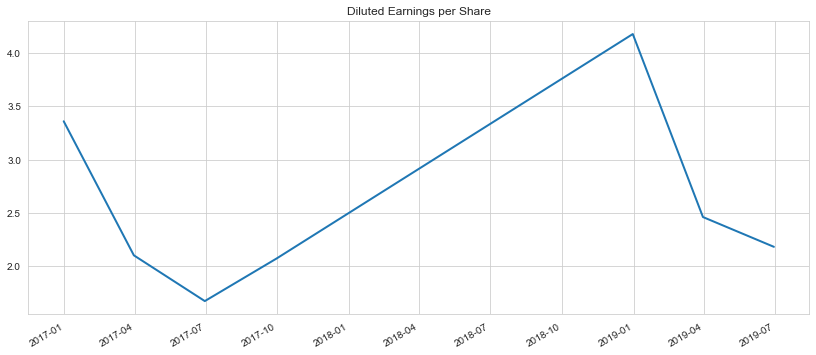

In [153]:
eps.plot(lw=2, figsize=(14, 6), title='Diluted Earnings per Share')
plt.xlabel('')
plt.savefig('diluted eps', dps=300);

In [154]:
# quandle access key 넣어야 한다

aapl_stock = (web.
              DataReader(symbol, 'quandl', start=eps.index.min(), access_key='skCv2hHSG2bAkBmeokuM')
              .resample('D')
              .last()
             .loc['2014':eps.index.max()])
aapl_stock.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 449 entries, 2017-01-03 to 2018-03-27
Freq: D
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Open        308 non-null    float64
 1   High        308 non-null    float64
 2   Low         308 non-null    float64
 3   Close       308 non-null    float64
 4   Volume      308 non-null    float64
 5   ExDividend  308 non-null    float64
 6   SplitRatio  308 non-null    float64
 7   AdjOpen     308 non-null    float64
 8   AdjHigh     308 non-null    float64
 9   AdjLow      308 non-null    float64
 10  AdjClose    308 non-null    float64
 11  AdjVolume   308 non-null    float64
dtypes: float64(12)
memory usage: 45.6 KB


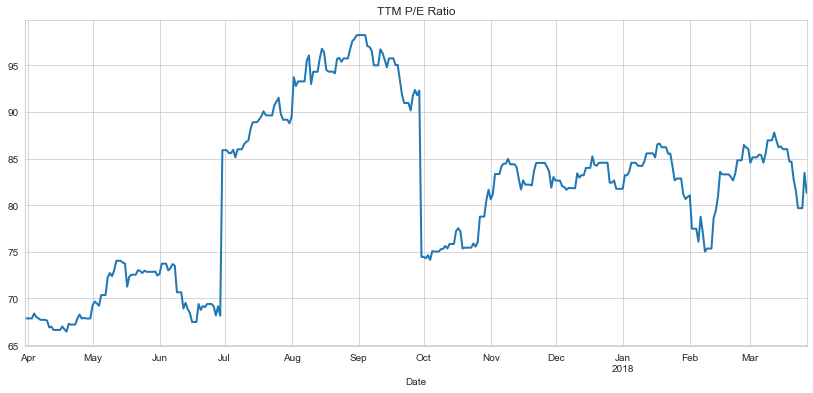

In [155]:
pe = aapl_stock.AdjClose.to_frame('price').join(eps.to_frame('eps'))
pe = pe.fillna(method='ffill').dropna()
pe['P/E Ratio'] = pe.price.div(pe.eps)
pe['P/E Ratio'].plot(lw=2, figsize=(14, 6), title='TTM P/E Ratio');

In [156]:
pe.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 362 entries, 2017-03-31 to 2018-03-27
Freq: D
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   price      362 non-null    float64
 1   eps        362 non-null    float64
 2   P/E Ratio  362 non-null    float64
dtypes: float64(3)
memory usage: 11.3 KB


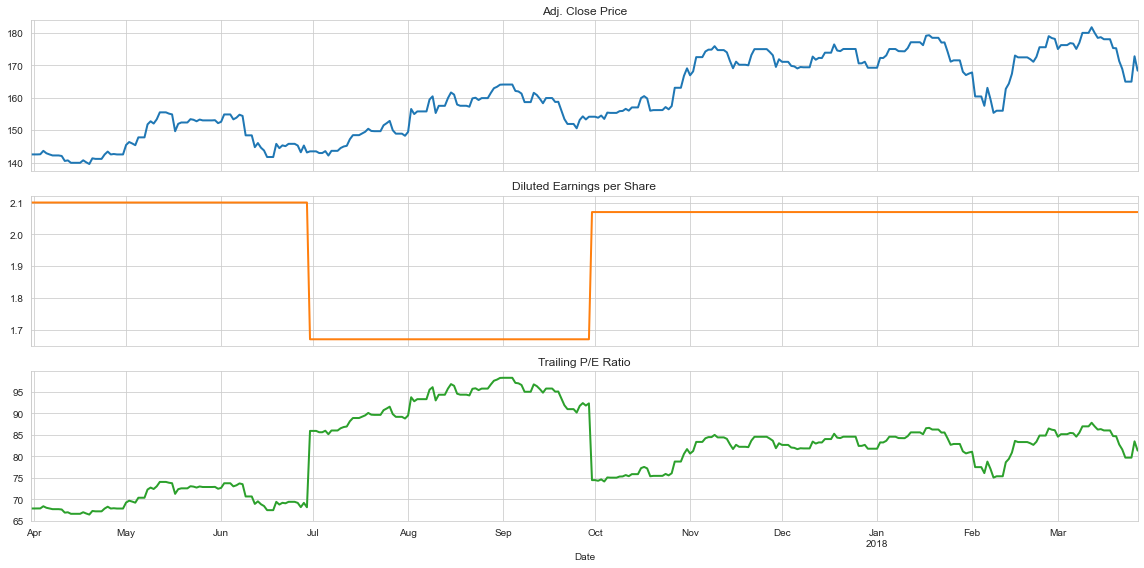

In [157]:
axes = pe.plot(subplots=True, figsize=(16,8), legend=False, lw=2)
axes[0].set_title('Adj. Close Price')
axes[1].set_title('Diluted Earnings per Share')
axes[2].set_title('Trailing P/E Ratio')
plt.tight_layout();

## Explore Additional Fields

The field `tag` references values defined in the taxonomy:

In [36]:
aapl_nums.tag.value_counts()

CashAndCashEquivalentsAtCarryingValue                                                                             810
DebtInstrumentInterestRateEffectivePercentage                                                                     782
OperatingIncomeLoss                                                                                               650
AvailableForSaleSecuritiesNoncurrent                                                                              560
AvailableForSaleSecuritiesCurrent                                                                                 560
                                                                                                                 ... 
DeferredTaxAssetsGoodwillAndIntangibleAssets                                                                        1
ShareBasedCompensationArrangementsByShareBasedPaymentAwardOptionsGrantsInPeriodWeightedAverageExercisePrice         1
TaxCutsAndJobsActOf2017MeasurementPeriodAdjustmentIncome

### Dividends per Share

In [161]:
fields = ['EarningsPerShareDiluted',
          'PaymentsOfDividendsCommonStock',
          'WeightedAverageNumberOfDilutedSharesOutstanding',
          'OperatingIncomeLoss',
          'NetIncomeLoss',
          'GrossProfit']

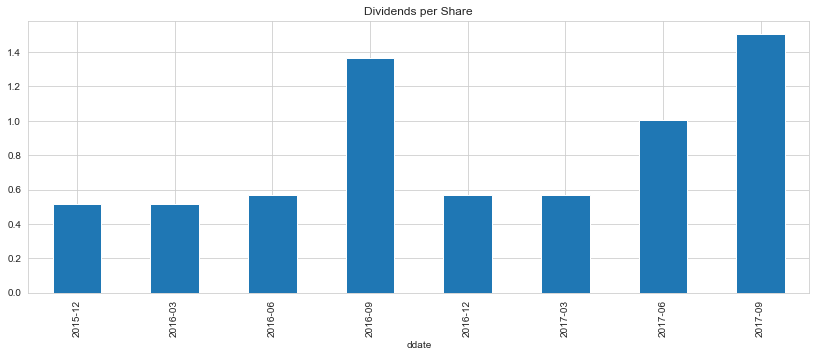

In [162]:
dividends = (aapl_nums
             .loc[aapl_nums.tag == 'PaymentsOfDividendsCommonStock', ['ddate', 'value']]
             .groupby('ddate')
             .mean())
shares = (aapl_nums
          .loc[aapl_nums.tag == 'WeightedAverageNumberOfDilutedSharesOutstanding', ['ddate', 'value']]
          .drop_duplicates()
          .groupby('ddate')
          .mean())
df = dividends.div(shares).dropna()
ax = df.plot.bar(figsize=(14, 5), title='Dividends per Share', legend=False)
ax.xaxis.set_major_formatter(mticker.FixedFormatter(df.index.strftime('%Y-%m')))

## Bonus: Textual Information

In [165]:
txt = pd.read_parquet(data_path / '2017_1' / 'parquet' /  'txt.parquet')

AAPL's adsh is not avaialble in the txt file but you can obtain notes from the financial statements here:

In [166]:
txt.head()

,adsh,tag,version,ddate,qtrs,iprx,lang,dcml,durp,datp,dimh,dimn,coreg,escaped,srclen,txtlen,footnote,footlen,context,value
0,0001213900-17-000031,EntityRegistrantName,dei/2014,20160930,3,0,en-US,32767,0.00822,0.0,0x00000000,0,None,0,19,19,None,0,Context_9ME_01_Jan_2016T00_00_00_TO_30_Sep_201...,Kornit Digital Ltd.
1,0001213900-17-000031,EntityCentralIndexKey,dei/2014,20160930,3,0,en-US,32767,0.00822,0.0,0x00000000,0,None,0,10,10,None,0,Context_9ME_01_Jan_2016T00_00_00_TO_30_Sep_201...,0001625791
2,0001213900-17-000031,AmendmentFlag,dei/2014,20160930,3,0,en-US,32767,0.00822,0.0,0x00000000,0,None,0,5,5,None,0,Context_9ME_01_Jan_2016T00_00_00_TO_30_Sep_201...,false
3,0001213900-17-000031,CurrentFiscalYearEndDate,dei/2014,20160930,3,0,en-US,32767,0.00822,0.0,0x00000000,0,None,0,7,7,None,0,Context_9ME_01_Jan_2016T00_00_00_TO_30_Sep_201...,--12-31
4,0001213900-17-000031,DocumentType,dei/2014,20160930,3,0,en-US,32767,0.00822,0.0,0x00000000,0,None,0,3,3,None,0,Context_9ME_01_Jan_2016T00_00_00_TO_30_Sep_201...,6-K
